<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/IDW_exp_PM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.1 MB/s eta 0:00:00


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 65.9 MB/s eta 0:00:00


# IDW - Additive Method

In [93]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools
from sklearn.neighbors import BallTree

# === Load CSV Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (Observed - Modeled)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Convert degrees to radians (for Haversine calculations)
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon_rad, lat_rad)
points_grid = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# Prepare Station Data (Convert to Radians)
station_lons_rad = np.radians(df["nearest_grid_lon"].values)
station_lats_rad = np.radians(df["nearest_grid_lat"].values)
station_points = np.column_stack([station_lats_rad, station_lons_rad])
bias_values = df["bias"].values

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # p (Decay Rate)
k_values = np.arange(2, 41, 1).tolist()  # k (Number of Neighbors)

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Exponential IDW") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_values[train_index], bias_values[test_index]

            train_tree = BallTree(train_points, metric="haversine")
            predicted_bias = []

            for test_point in test_points:
                dists, idxs = train_tree.query([test_point], k=k)

                dists = dists.flatten()
                idxs = idxs.flatten()

                if np.any(dists == 0):  # Exact match case
                    predicted_bias.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = np.exp(-p * dists)  # Exponential Decay Weighting
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_EXP_Val.csv", index=False)

print(f"\n Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW with Optimized `p` and `k` ===
def idw_exponential(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.zeros(grid_points.shape[0])

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = np.exp(-p * dists_non_zero)
    weights /= np.sum(weights, axis=1, keepdims=True)

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Bias with Best Hyperparameters
print("\n Applying Exponential Decay IDW with Optimized p & k...")
interpolated_bias_exp = idw_exponential(points_grid, station_points, bias_values, best_params[0], best_params[1])
interpolated_bias_exp = interpolated_bias_exp.reshape(pm25_modeled.shape)

# === Save Bias Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_var = new_dataset.createVariable("Interpolated_Bias", "f4", ("lat", "lon"))

bias_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Interpolated Bias using Exponential Decay IDW (Optimized p & k, No Time Dimension, Haversine BallTree)"

lat_var[:] = lat
lon_var[:] = lon
bias_var[:, :] = interpolated_bias_exp

new_dataset.close()
print(" Interpolated Bias Saved to:", bias_netcdf_path)


Grid Search for Exponential IDW: 100%|██████████| 1950/1950 [22:24<00:00,  1.45it/s]



 Best parameters found: p=5.0, k=3 with RMSE=0.5410

 Applying Exponential Decay IDW with Optimized p & k...
 Interpolated Bias Saved to: BaseCase_PM25_rh50_Y_IDW_EXP.nc


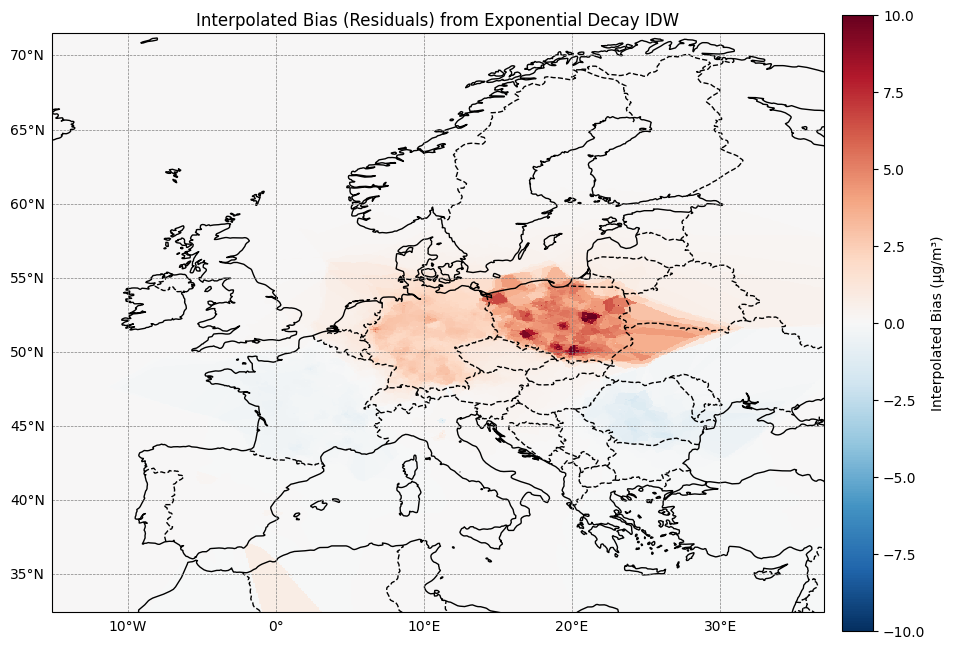

In [94]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias (residuals)
interpolated_bias = ds_bias["Interpolated_Bias"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -10  # Minimum bias value for color scale
cbar_max = 10   # Maximum bias value for color scale

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias
im = ax.pcolormesh(lon, lat, interpolated_bias, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolated Bias (Residuals) from Exponential Decay IDW")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()

In [95]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "BaseCase_PM25_rh50_Y_IDW_EXP.nc"
corrected_nc_path = "BaseCase_Corrected_PM25_rh50_Y_EXP.nc"

# === Load the Original Modeled PM₂.₅ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]

    # Load the interpolated bias
    interpolated_bias = bias_nc.variables["Interpolated_Bias"][:]

    # === Compute the Unbiased PM₂.₅ ===
    pm25_corrected = pm25_original + interpolated_bias  # Apply the bias correction

    # === Save the Corrected PM₂.₅ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original PM₂.₅ variable
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected  # Store corrected PM₂.₅

print(" Bias correction completed successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)


 Bias correction completed successfully!
 Corrected PM₂.₅ NetCDF file saved as: BaseCase_Corrected_PM25_rh50_Y_EXP.nc


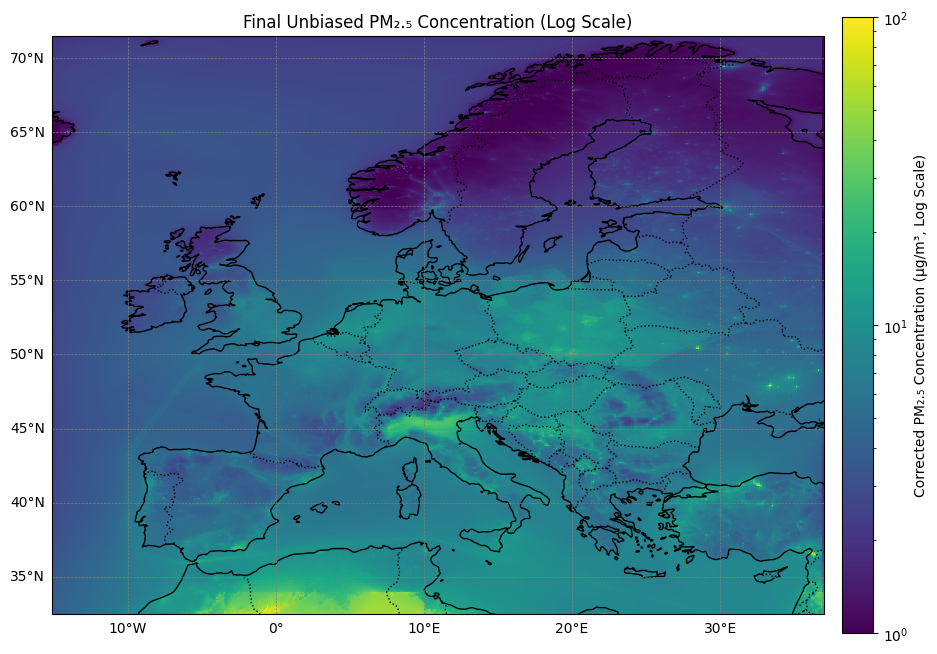

In [96]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected PM₂.₅ NetCDF File ===
corrected_netcdf_path = "BaseCase_Corrected_PM25_rh50_Y_EXP.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected PM₂.₅ values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log scale between 1 and max value

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM₂.₅ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_pm25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected PM₂.₅ Concentration (µg/m³, Log Scale)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Final Unbiased PM₂.₅ Concentration (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


# IDW- Multiplicative Mehod

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.neighbors import BallTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Load CSV Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias ratio (Observed / Modeled)
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([np.radians(lat_mesh.ravel()), np.radians(lon_mesh.ravel())])  # Convert to radians for BallTree

# Prepare Station Data
station_points = np.column_stack([np.radians(df["nearest_grid_lat"].values), np.radians(df["nearest_grid_lon"].values)])  # Convert to radians
bias_ratios = df["bias_ratio"].values

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # p (Decay Rate)
k_values = np.arange(2, 41, 1).tolist()  # k (Number of Neighbors)

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Exponential IDW Multiplicative (BallTree)") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_ratios[train_index], bias_ratios[test_index]

            train_tree = BallTree(train_points, metric="haversine")  # Use BallTree with Haversine distance
            dists, idxs = train_tree.query(test_points, k=k)

            predicted_bias_ratio = []
            for i in range(len(test_points)):
                if np.any(dists[i] == 0):
                    predicted_bias_ratio.append(train_values[idxs[i][dists[i] == 0]][0])
                else:
                    weights = np.exp(-p * dists[i])  # Exponential Decay Weighting
                    interpolated_ratio = np.sum(weights * train_values[idxs[i]]) / np.sum(weights)
                    predicted_bias_ratio.append(interpolated_ratio)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias_ratio))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_EXP_MUL_Val.csv", index=False)

print(f"\n Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW Multiplicative with Optimized `p` and `k` ===
def idw_multiplicative(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")  # Use BallTree with Haversine distance
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.ones(grid_points.shape[0])  # Initialize with 1 (Multiplicative method)

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = np.exp(-p * dists_non_zero)
    weights /= np.sum(weights, axis=1, keepdims=True)

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Bias Ratio with Best Hyperparameters
print("\n Applying Exponential Decay IDW Multiplicative with Optimized p & k (BallTree)...")
interpolated_ratio_exp = idw_multiplicative(points_grid, station_points, bias_ratios, best_params[0], best_params[1])
interpolated_ratio_exp = interpolated_ratio_exp.reshape(pm25_modeled.shape)

# === Save Bias Ratio Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_ratio_var = new_dataset.createVariable("Interpolated_Bias_Ratio", "f4", ("lat", "lon"))

bias_ratio_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Interpolated Bias Ratio using Exponential Decay IDW Multiplicative (Optimized p & k, No Time Dimension, BallTree with Haversine)"

lat_var[:] = lat
lon_var[:] = lon
bias_ratio_var[:, :] = interpolated_ratio_exp

new_dataset.close()
print("Interpolated Bias Ratio Saved to:", bias_netcdf_path)


Grid Search for Exponential IDW Multiplicative: 100%|██████████| 1950/1950 [07:20<00:00,  4.43it/s]



✅ Best parameters found: p=5.0, k=12 with RMSE=0.0555

🚀 Applying Exponential Decay IDW Multiplicative with Optimized p & k...
✅ Interpolated Bias Ratio Saved to: BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc


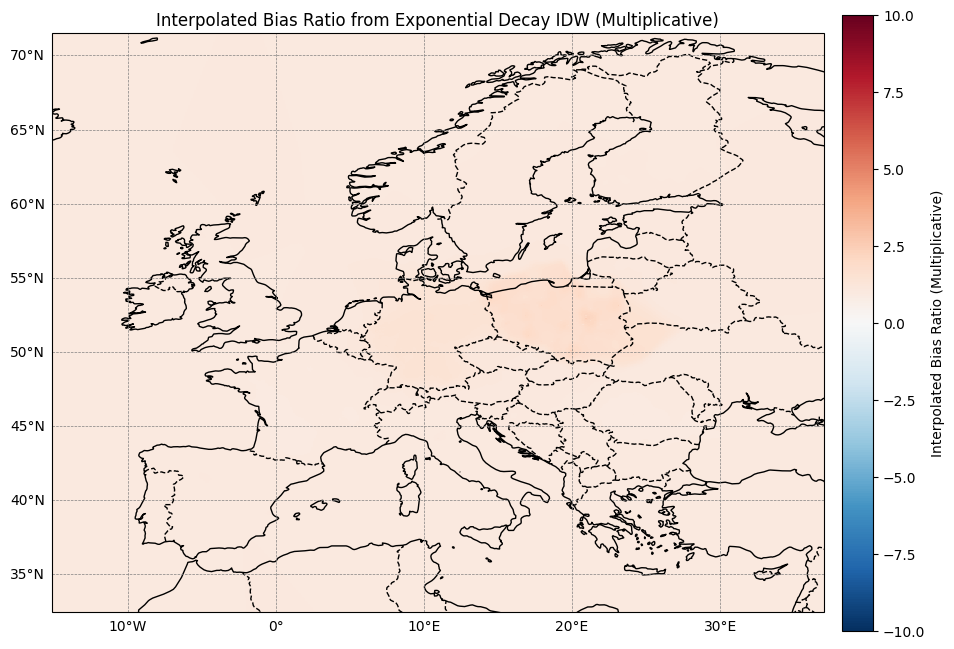

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias Ratio NetCDF File ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias ratio
interpolated_bias_ratio = ds_bias["Interpolated_Bias_Ratio"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -10  # Set minimum scale for bias ratio
cbar_max = 10  # Set maximum scale for bias ratio

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias ratio
im = ax.pcolormesh(lon, lat, interpolated_bias_ratio, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias Ratio (Multiplicative)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolated Bias Ratio from Exponential Decay IDW (Multiplicative)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()


In [ ]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_ratio_nc_path = "BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc"
corrected_nc_path = "BaseCase_Corrected_PM25_rh50_Y_EXP_MUL.nc"

# === Load the Original Modeled PM₂.₅ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_ratio_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]

    # Load the interpolated bias ratio
    interpolated_bias_ratio = bias_nc.variables["Interpolated_Bias_Ratio"][:]

    # === Compute the Unbiased PM₂.₅ (Multiplicative Correction) ===
    pm25_corrected = pm25_original * interpolated_bias_ratio  # Apply the multiplicative bias correction

    # === Save the Corrected PM₂.₅ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original PM₂.₅ variable
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected  # Store corrected PM₂.₅

print(" Multiplicative Bias Correction Completed Successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)


✅ Multiplicative Bias Correction Completed Successfully!
🚀 Corrected PM₂.₅ NetCDF file saved as: BaseCase_Corrected_PM25_rh50_Y_EXP_MUL.nc


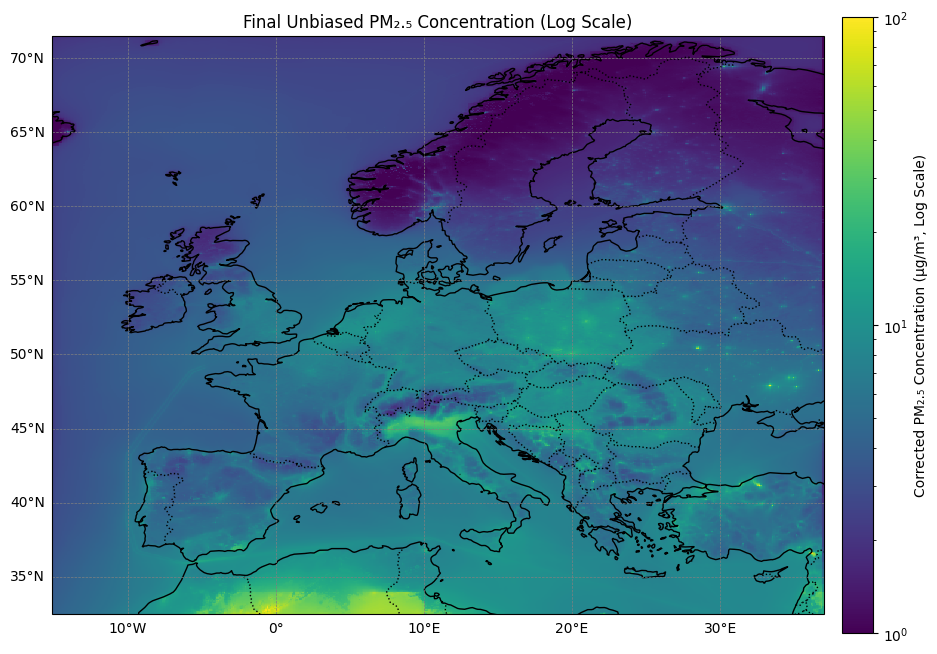

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected PM₂.₅ NetCDF File ===
corrected_netcdf_path = "BaseCase_Corrected_PM25_rh50_Y_EXP_MUL.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected PM₂.₅ values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log scale between 1 and max value

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM₂.₅ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_pm25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected PM₂.₅ Concentration (µg/m³, Log Scale)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Final Unbiased PM₂.₅ Concentration (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


# IDW - Hybrid Correction (Additive & Multiplicative)

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.neighbors import BallTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Load CSV Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Compute Multiplicative Bias Ratio
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["bias_ratio"], inplace=True)

# Load NetCDF Data
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract Grid Coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
grid_coords = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Convert coordinates to radians for Haversine distance
grid_coords_rad = np.radians(grid_coords)

# Prepare Station Data
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_additive_values = df["bias_additive"].values
bias_ratio_values = df["bias_ratio"].values

# Convert station coordinates to radians
station_points_rad = np.radians(station_points)

# Build BallTree using Haversine Distance
tree = BallTree(station_points_rad, metric="haversine")

# === Hyperparameter Optimization (p, k) ===
p_values = np.arange(0.5, 5.1, 0.1).tolist()
k_values = np.arange(2, 41, 1).tolist()
threshold = 5  # Hybrid threshold

kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Hybrid IDW") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_additive_values = bias_additive_values[train_index]
            train_ratio_values = bias_ratio_values[train_index]

            test_additive_values = bias_additive_values[test_index]
            test_ratio_values = bias_ratio_values[test_index]

            train_tree = BallTree(np.radians(train_points), metric="haversine")

            predicted_bias_hybrid = []

            for test_point in np.radians(test_points):
                dists, idxs = train_tree.query([test_point], k=k)

                if np.any(dists == 0):
                    interpolated_bias = train_additive_values[idxs[dists == 0][0][0]]
                else:
                    weights = np.exp(-p * dists[0])
                    interpolated_additive = np.sum(weights * train_additive_values[idxs[0]]) / np.sum(weights)
                    interpolated_ratio = np.sum(weights * train_ratio_values[idxs[0]]) / np.sum(weights)

                    # Hybrid Correction Logic
                    modeled_value = pm25_modeled.ravel()[np.where((station_points == test_points).all(axis=1))[0][0]]
                    if modeled_value < threshold:
                        interpolated_bias = interpolated_additive  # Additive Correction
                    else:
                        interpolated_bias = (interpolated_ratio - 1) * modeled_value  # Multiplicative Correction

                predicted_bias_hybrid.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_additive_values, predicted_bias_hybrid))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_HAM_Val.csv", index=False)

print(f"\n Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply Hybrid IDW with Optimized Parameters ===
print("\n Applying Hybrid IDW with Optimized p & k...")
interpolated_bias_hybrid = np.zeros(grid_coords.shape[0])

for i in tqdm(range(grid_coords.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
    dists, idxs = tree.query([grid_coords_rad[i]], k=best_params[1])

    if np.any(dists == 0):
        interpolated_bias_hybrid[i] = bias_additive_values[idxs[dists == 0][0][0]]
    else:
        weights = np.exp(-best_params[0] * dists[0])
        interpolated_additive = np.sum(weights * bias_additive_values[idxs[0]]) / np.sum(weights)
        interpolated_ratio = np.sum(weights * bias_ratio_values[idxs[0]]) / np.sum(weights)

        # Apply Hybrid Correction
        if pm25_modeled.ravel()[i] < threshold:
            interpolated_bias_hybrid[i] = interpolated_additive
        else:
            interpolated_bias_hybrid[i] = (interpolated_ratio - 1) * pm25_modeled.ravel()[i]

# Reshape the interpolated bias
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# === Save Bias Correction NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_HAM.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_var = new_dataset.createVariable("Interpolated_Hybrid_Bias", "f4", ("lat", "lon"))

bias_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Interpolated Bias using Hybrid IDW (Optimized p & k, No Time Dimension)"

lat_var[:] = lat
lon_var[:] = lon
bias_var[:, :] = interpolated_bias_hybrid

new_dataset.close()
print(" Hybrid IDW Bias Saved to:", bias_netcdf_path)


<ipython-input-45-dc383f30ea84>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
Grid Search for Hybrid IDW:   5%|▌         | 90/1794 [09:20<2:56:43,  6.22s/it]


KeyboardInterrupt: 

In [ ]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "BaseCase_PM25_rh50_Y_IDW_HAM.nc"
corrected_nc_path = "BaseCase_Corrected_PM25_rh50_Y_IDW_HAM.nc"

# === Load the Original Modeled PM₂.₅ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]

    # Load the interpolated hybrid bias
    interpolated_hybrid_bias = bias_nc.variables["Interpolated_Hybrid_Bias"][:]

    # === Compute the Unbiased PM₂.₅ ===
    pm25_corrected = pm25_original + interpolated_hybrid_bias  # Apply the hybrid correction

    # === Save the Corrected PM₂.₅ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original PM₂.₅ variable
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected  # Store corrected PM₂.₅

print(" Hybrid Bias Correction Completed Successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)